# Assignment 3

## Main tasks

### Tasks 1,2

I suppose that:
* each joint has `q_params` and `t0`
* points are given in the joint space


In [1]:
import numpy as np
from sympy.solvers.solvers import solve

# Assumptions:
#   t_params: [t0, tau, T, t_f] 
#     tau is the time of acceleration end
#     T is the start of deceleration start

In [2]:

# q_params = [q0, qf, dq_max, ddq_max]
# t0=   #initial trajectory time

# q_params_list = [] #list of q_params


In [3]:
def trajectory_time(q_params, t0): 
  '''
  q_params: [q0, qf, dq, ddq]
  t0: initial time of motion

  Output: 
  t_params: [t0, tau, T, t_f]
  '''
  
  q0, qf, dq, ddq = q_params
  delta_q = qf-q0
  tau, T = 0, 0

  if np.sqrt(np.abs(delta_q) * ddq) <= dq:
    # triangular profile
    tau = np.sqrt(np.abs(delta_q) / ddq)
    T = tau
  
  else:
    # trapezoidal profile
    tau = dq / ddq
    T = delta_q / dq

  t_params = t0 + np.array([0, tau, T, T + tau])

  return t_params


In [4]:
q_params=[10,45,8,4]
t0 = 0

print(trajectory_time(q_params, t0))

[0.    2.    4.375 6.375]


In [5]:

def trapezoidal_trajectory(q_params, t_params, sync=False):
  '''
  t_params: [t0, tau, T, t_f]

  Output: 
  t: list of timesteps from t0 till tf
  q: list of positions from q0 to qf
  v: list of velocities from beginning to end of motion
  a: list of accelerations from beginning to end of motion
  '''
  
  t0, tau, T, t_f = t_params

  t = np.linspace(start=t0, stop=t_f, num=N)
  
  q0, qf, dq_max, ddq_max = q_params
  
  dq, ddq = 0,0
  
  if sync:
    delta_q = qf-q0
    dq = delta_q / (T - t0)
    ddq = dq / (tau - t0)

  else: 
    dq = dq_max
    ddq = ddq_max

  qs = np.zeros(N)
  dqs = np.zeros(N)
  ddqs = np.zeros(N)

  for i in range(N):
    if t[i] <= tau:
      # acceleration
      qs[i] = q0 + 1/2 * ddq * (t[i] - t0)**2
      dqs[i] = ddq * (t[i] - t0)
      ddqs[i] = ddq

    elif t[i] <= T:
      # steady velocity
      qs[i] = q0 - 1/2 * ddq * (tau - t0)**2 + dq * (t[i] - t0)
      dqs[i] = dq
      ddqs[i] = 0

    else:
      # deceleration
      qs[i] = qf - 1/2 * ddq * (t_f - t[i])**2
      dqs[i] = ddq * (t_f - t[i])
      ddqs[i] = -ddq

  q = qs
  v = dqs
  a = ddqs

  return t, q, v, a



In [6]:
N = 1000

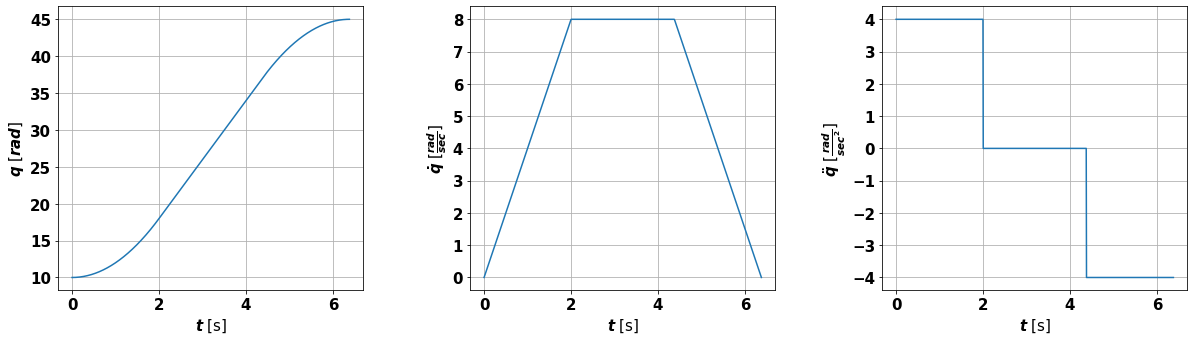

In [7]:

# check trapezoidal_trajectory, trajectory_time

traj = trapezoidal_trajectory(q_params, trajectory_time(q_params, t0))

from utils import plot_list
plot_list([
  {
    'x': traj[0],
    'xlabel': "$t$ [s]",
    'ylabel': "$q$ [$rad$]",
    'graphs': [{"y": traj[1]}]
  },
  {
    'x': traj[0],
    'xlabel': "$t$ [s]",
    'ylabel': "$\dot{q}$ [$\\frac{rad}{sec}$]",
    'graphs': [{"y": traj[2]}]
  },
  {
    'x': traj[0],
    'xlabel': "$t$ [s]",
    'ylabel': "$\ddot{q}$ [$\\frac{rad}{sec^2}$]",
    'graphs': [{"y": traj[3]}]
  },
  ])


In [8]:

def time_synch(t_params_list): 
  '''
  t_params_list: a list of lists of time params of each joint motion [t_params_1, t_params_2, .....t_params_n]

  Output: 
  t_params_sync: list of synchronized time params [t_0, tau, T, t_f]
  '''

  t_params = np.array(t_params_list)
  
  # select max start time
  t0 = np.amax(t_params[:,0])
  
  # make start times the same for all joints
  for t in t_params:
    t += t0 - t[0]

  # select max tau
  tau = np.amax(t_params[:,1])

  # select max steady velocity time
  tau_T = np.amax(t_params[:,2] - t_params[:,1])

  T = tau + tau_T

  t_f = T + tau - t0

  t_params_sync = np.array([t0, tau, T, t_f])

  return t_params_sync



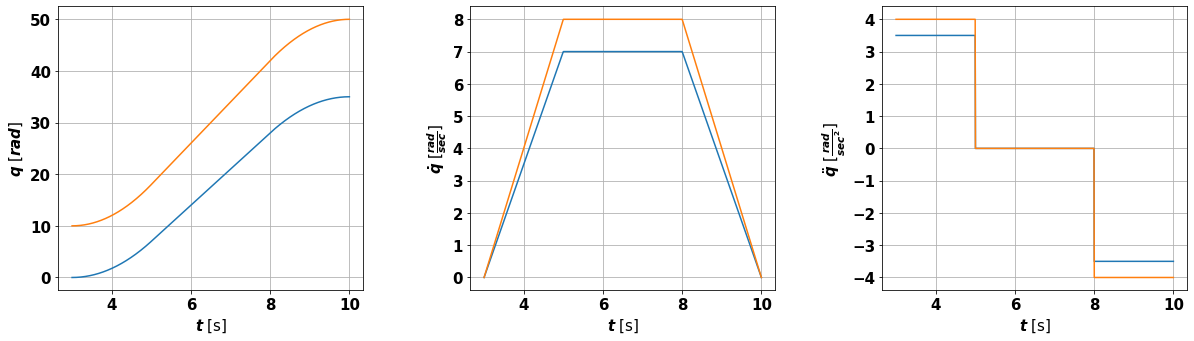

In [9]:

# check time_synch

q_params_list = np.array(
  [
    [0, 35, 8, 4],
    [10, 50, 8, 4]
  ]
)

t0_list = np.array(
  [
    0,
    3
  ]
)
t_params_list = np.array([trajectory_time(i, j) for i,j in zip(q_params_list, t0_list)])

t_synced = time_synch(t_params_list)

traj_list = np.array([trapezoidal_trajectory(i, t_synced, sync=True) for i in q_params_list])

ts = traj_list[0,0]

plot_list([
  {
    'x': ts,
    'xlabel': "$t$ [s]",
    'ylabel': "$q$ [$rad$]",
    'graphs': [{"y": i[1]} for i in traj_list]
  },
  {
    'x': ts,
    'xlabel': "$t$ [s]",
    'ylabel': "$\dot{q}$ [$\\frac{rad}{sec}$]",
    'graphs': [{"y": i[2]} for i in traj_list]
  },
  {
    'x': ts,
    'xlabel': "$t$ [s]",
    'ylabel': "$\ddot{q}$ [$\\frac{rad}{sec^2}$]",
    'graphs': [{"y": i[3]} for i in traj_list]
  },
  ])


In [10]:
def trapezoid_p2p(q_params_list, t0_list):
  '''
  q_params_list: list of lists of actuator parameters 
  t0_list: list of moments at which joints can start motion

  Output: 
  t: list of time steps
  q: list of joint positions after synchronization [[q1], [q2] ...[qn]]
  dq, ddq: list of lists of joint velocities and accelerations in the same format as q
  '''
  # There was no description of t_params_sync, so I removed it

  t_params_list = np.array([trajectory_time(i, j) for i,j in zip(q_params_list, t0_list)])
  t_params_sync = time_synch(t_params_list)
  traj_list = np.array([trapezoidal_trajectory(i, t_params_sync, sync=True) for i in q_params_list])
  
  t = traj_list[0,0]
  q = traj_list[:,1]
  dq = traj_list[:,2]
  ddq = traj_list[:,3]

  return t, q, dq, ddq


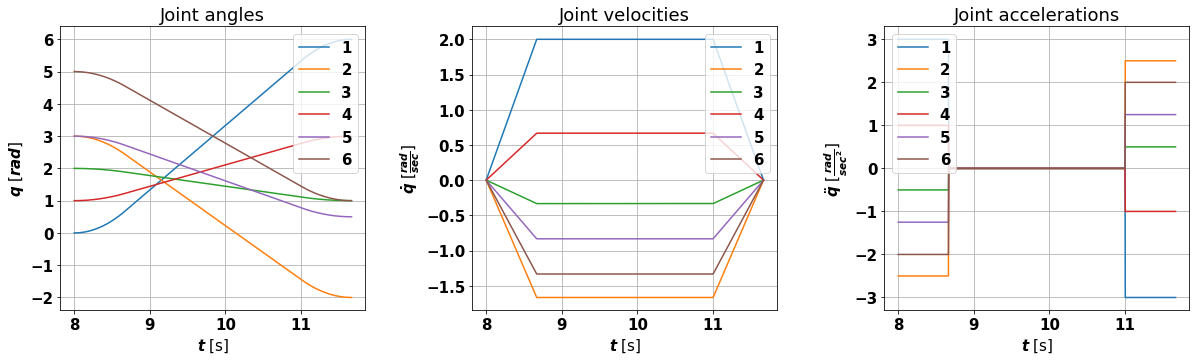

In [11]:

q_params_list = np.array(
  [
    [0, 6, 2, 3],
    [3, -2, 2, 3],
    [2, 1, 2, 3],
    [1, 3, 2, 3],
    [3, 0.5, 2, 3],
    [5, 1, 2, 3],
  ]
)

t0_list = np.array(
  [
    0,
    3,
    6,
    8,
    4,
    5
  ]
)

p2p = trapezoid_p2p(q_params_list, t0_list)

labels = [f'{i}' for i in range(1,7)]

plot_list([
  {
    'x': p2p[0],
    'xlabel': "$t$ [s]",
    'ylabel': "$q$ [$rad$]",
    'title': "Joint angles",
    'graphs': [{"y": i, "label": j} for i,j in zip(p2p[1], labels)]
  },
  {
    'x': p2p[0],
    'xlabel': "$t$ [s]",
    'ylabel': "$\dot{q}$ [$\\frac{rad}{sec}$]",
    'title': "Joint velocities",
    'graphs': [{"y": i, "label": j} for i,j in zip(p2p[2], labels)]
  },
  {
    'x': p2p[0],
    'xlabel': "$t$ [s]",
    'ylabel': "$\ddot{q}$ [$\\frac{rad}{sec^2}$]",
    'title': "Joint accelerations",
    'graphs': [{"y": i, "label": j} for i,j in zip(p2p[3], labels)]
  },
  ])


### Task 5

In [12]:
import sympy as sp

def solve_cubic_3(t_list, q_list, dqs):
  a13, a12, a11, a10 = sp.symbols("a13 a12 a11 a10")
  a23, a22, a21, a20 = sp.symbols("a23 a22 a21 a20")
  t1, t2, t3 = [sp.Matrix([j**i for i in range(3,-1,-1)]) for j in t_list]
  q1, q2, q3 = q_list
  v1, v3 = dqs

  m1 = sp.Matrix([
    [a13, a12,   a11,   a10],
    [0,   3*a13, 2*a12, a11],
  ])
  c1 = sp.Matrix([q1, v1])

  m2 = sp.Matrix([
    [a23, a22,   a21,   a20],
    [0,   3*a23, 2*a22, a21],
  ])
  c2 = sp.Matrix([q3, v3])

  m3 = sp.Matrix([
    [a13, a12,         a11,         a10        ],
    [a23, a22,         a21,         a20        ],
    [0,   3*(a13-a23), 2*(a12-a22),  a11-a21   ],
    [0,   0,           6*(a13-a23), 2*(a12-a22)]
  ])
  c3 = sp.Matrix([q2,q2,0,0])

  eq1 = m1 * t1 - c1
  eq2 = m2 * t3 - c2
  eq3 = m3 * t2 - c3

  sol = sp.solve([eq1, eq2, eq3])
  
  coeffs = np.array([
    [sol[a10], sol[a11], sol[a12], sol[a13]],
    [sol[a20], sol[a21], sol[a22], sol[a23]]
  ])
  
  return coeffs


In [13]:

# check solve_cubic_3

q_list = [2.,3.,2.]
t_list = [1.,3.,5.]
dqs = [0., 0.]
# print(solve_cubic_3(t_list,q_list,dqs))


In [14]:

import numpy as np
import matplotlib.pyplot as plt

q_list = [2.,3.,-4.]
t_list = [1.,3.,5.]
dqs = [0., 0.]
N = 100

def get_cubic_data(t_list, q_list, dqs, N):
  cs = solve_cubic_3(t_list, q_list, dqs)
  xs = np.array([np.linspace(t_list[i], t_list[i+1], N) for i in range(2)])
  ys = np.array([np.sum([xs[j]**i * cs[j,i] for i in range(4)], axis=0) for j in range(2)])
  x = xs.ravel()
  y = ys.ravel()
  return x, y


check `get_cubic_data`

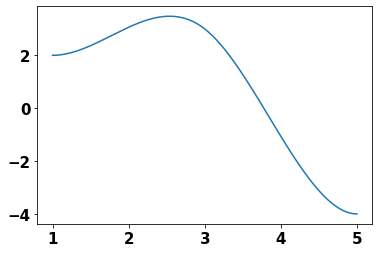

In [15]:
x,y = get_cubic_data(t_list, q_list, dqs, N)
fig, ax = plt.subplots()
ax.plot(x,y)

In [16]:

def get_joint_trajectories(ts, qs, dqs, N):
  return np.array([get_cubic_data(ts,i,j,N) for i,j in zip(qs,dqs)])


np.random.seed(42)
qs = [np.random.uniform(size=3, low=-np.pi, high=np.pi) for i in range(6)]
ts = np.sort(np.random.uniform(size=3, low=0, high = 10))
dqs = [np.random.uniform(low=-5, high=5,size=2) for i in range(6)]

trs = get_joint_trajectories(ts, qs, dqs, N)

labels = [f'{i}' for i in range(1,7)]
xs = trs[0,0]

# print(qs)

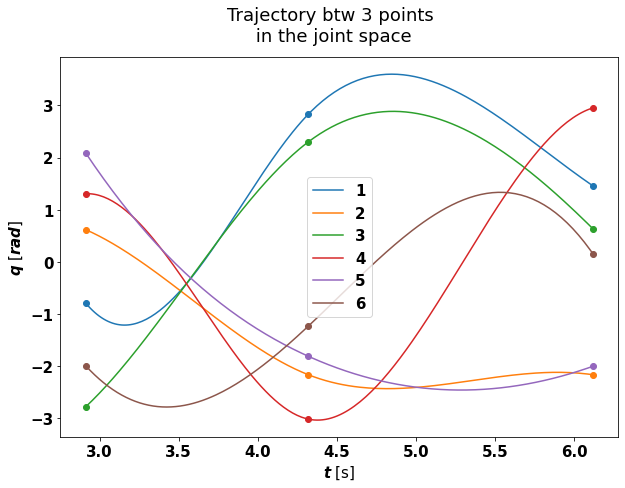

In [17]:

# Plot trajectory between points

fig, ax = plt.subplots()

for i in range(6):
  ax.plot(xs, trs[i,1], label=labels[i])
  ax.scatter(ts, qs[i])
  ax.set_xlabel("$t$ [s]")
  ax.set_ylabel("$q$ [$rad$]")

fig.suptitle("Trajectory btw 3 points\n in the joint space")
fig.set_figwidth(10)
fig.set_figheight(7)
ax.legend()

plt.show()


## Bonus task


In [18]:

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def solve_splines(x, y):
  """
  t_list: list of 3 moments at which given angles should be reached
  q_list: list of 3 angles that are needed to reach

  Output: 
  t: list of time steps
  q: list of joint positions after synchronization [[q1], [q2] ...[qn]]
  dq, ddq: list of lists of joint velocities and accelerations in the same format as q
  """
  
  # initial and final velocities are zero
  # initial and final accelerations are zero
  # hence, can use https://en.wikipedia.org/wiki/Spline_(mathematics)#Algorithm_for_computing_natural_cubic_splines
  
  n = len(x)-1
  a = np.array(y)
  
  b = np.zeros(n)
  
  d = np.zeros(n)
  
  h = np.array([x[i+1] - x[i] for i in range(n)])
  
  alpha = np.zeros(n)
  for i in range(1,n):
    alpha[i] = 3 / h[i] * (a[i+1] - a[i]) - 3 / h[i-1] * (a[i] - a[i-1])

  c, l, mu, z = np.zeros((4,n+1))
  l[0] = 1

  for i in range(1,n):
    l[i] = 2 * (x[i+1] - x[i-1]) - h[i-1] * mu[i-1]
    mu[i] = h[i] / l[i]
    z[i] = (alpha[i] - h[i-1] * z[i-1]) / l[i]

  l[n] = 1
  z[n] = 0
  c[n] = 0
  
  for j in range(n-1,-1,-1):
    c[j] = z[j] - mu[j] * c[j+1]
    b[j] = (a[j+1] - a[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j]) / 3
    d[j] = (c[j+1] - c[j]) / (3 * h[j])

  return a[:n],b[:n],c[:n],d[:n]


In [19]:

def get_spline_traj_data(cs, t, N=100):
  a,b,c,d = cs
  ts = np.linspace(t[0], t[-1], N)
  s = np.zeros(N)

  j = 0
  for i in range(N):
    if ts[i] > t[j+1]:
      j += 1
    
    dt = ts[i] - t[j]
    s[i] = a[j] + b[j]*dt + c[j]*dt**2 + d[j]*dt**3
  
  return s


test spline

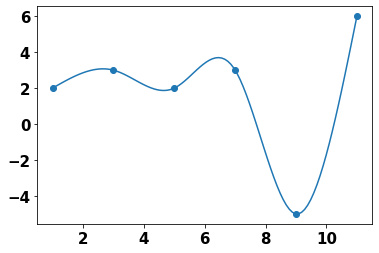

In [20]:
t_list = [1.,3,5.,7.,9.,11]
q_list = [2.,3.,2.,3,-5,6]

N = 100
cs = solve_splines(t_list, q_list)
ys = get_spline_traj_data(cs, t_list)
xs = np.linspace(t_list[0], t_list[-1], N)

fig, ax = plt.subplots()
ax.scatter(t_list, q_list)
ax.plot(xs,ys)

In [21]:

def get_spline_ys(t_list, q_list, N=100):
  return get_spline_traj_data(solve_splines(t_list, q_list),t_list, N)

In [22]:
from utils import pose_from_t, get_ik_from_pose, IK_solve

def straight_line(p0, pf, t0, tf, N=100):
    """
    p0: [x,y,z]
        start point
    pf: [x,y,z]
        end point

    output:
    time
    trajectories for all 6 joints
    """

    ps = np.linspace(p0, pf, N)
    qs = np.zeros((N, 6))
    qs[0] = get_ik_from_pose(p0)[0]
    j = 1
    for i in range(1,N):
        qi = np.array(get_ik_from_pose(ps[i]))
        j = i+1
        if len(qi) == 0:
            break

        dist = [np.linalg.norm(qi[k] - qs[i-1]) for k in range(len(qi))]
        qs[i] = qi[np.argmin(dist)]

    qs = qs[:j]
    ts = np.linspace(t0, tf, j)
    
    trajs = np.array([get_spline_ys(ts, qs[:,i],N=j) for i in range(len(p0))])

    return ts, trajs

In [23]:
def goes_through_singularity(p1,p2):
    ps = np.linspace(p1,p2)
    # print(ps)
    ok = True
    for i in ps:
        ok &= len(get_ik_from_pose(i)) != 0
    
    return not ok

In [24]:

goes_through_singularity(
    [3,0,1,1,2,0],
    [2,0,2,1,2,0]
    )

False

In [25]:

goes_through_singularity(
    [3,2,0,1,2,0],
    [2,0,2,1,2,0]
    )

False

In [50]:
# choose points in operational space
from utils import get_fk_solution, pose_from_t

t0 = 0
tf = 6
N = 1000

poses = [
    [3,2,0,1,2,0],
    [2,0,2,1,2,0]
    ]

# print(get_ik_from_pose(poses[0])[0])
# print(get_ik_from_pose(poses[1])[0])

ts, trs = straight_line(poses[0], poses[1], t0, tf, N)
ps = np.zeros((6,N))
for i in range(N):
    ps[:,i] = pose_from_t(get_fk_solution(trs[:,i]))

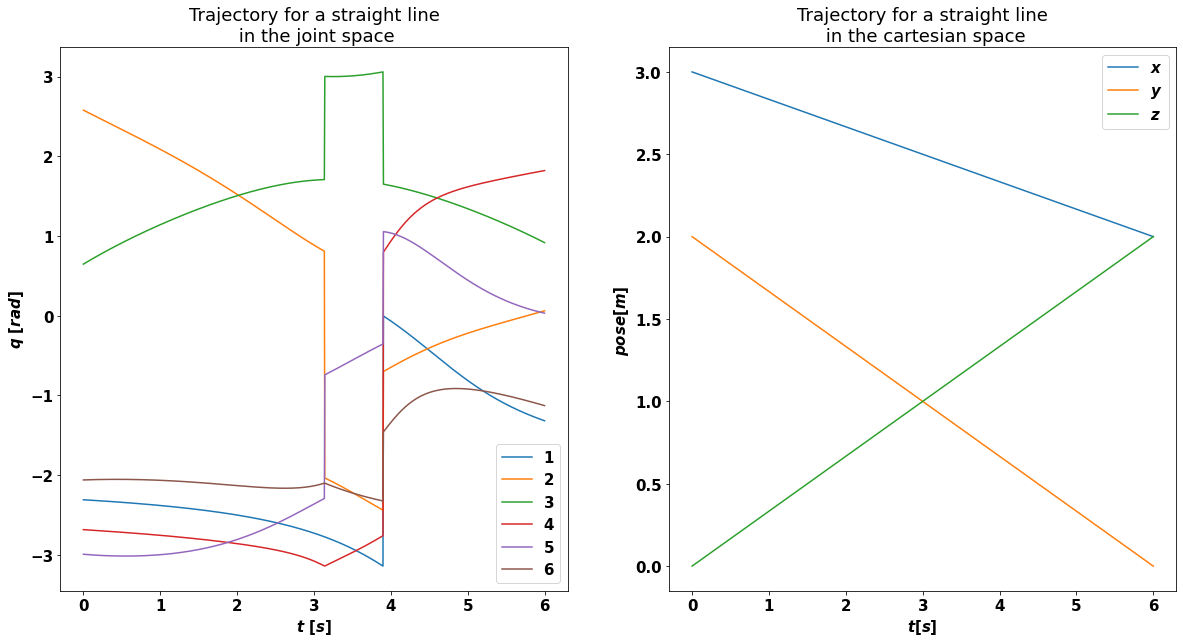

In [51]:

# Plot trajectory between points

fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(6):
  ax[0].plot(ts, trs[i], label=labels[i])
  ax[0].set_xlabel("$t\\ [s]$")
  ax[0].set_ylabel("$q\\ [rad]$")

# Check smoothness
# ax[0].set_xlim(3.135,3.1352)
# ax[0].set_ylim(0.8106,0.8108)

ax[0].legend()
ax[0].set_title("Trajectory for a straight line\n in the joint space")

pose_labels = ["$x$","$y$","$z$","$\\theta_x$","$\\theta_y$","$\\theta_z$"]
for i in range(3):
  ax[1].plot(ts, ps[i], label=pose_labels[i])
  ax[1].set_xlabel("$t [s]$ ")
  ax[1].set_ylabel("$pose [m]$ ")
ax[1].legend()
ax[1].set_title("Trajectory for a straight line\n in the cartesian space")


plt.show()

Probably, joints have to rotate very quickly sometimes, that's why I see such rapid changes. If you zoom, you will see more smooth curves 